In [61]:
# imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score

from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.base import BaseEstimator

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

from graphviz import Source
from sklearn import tree

RANDOM_STATE = 12

# import custom classes for pipeline
from prep import FeatureGemerator, FeatureSelector

In [62]:
# load_data 
df = pd.read_csv("BPL.csv")
df.sample(5)

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
3989,3990,49,25,90,92709,4,1.4,2,0,0,1,0,1,0
381,382,55,29,73,95616,2,2.3,3,0,0,0,0,1,1
4609,4610,54,28,80,95006,4,2.6,3,143,0,0,0,0,0
3388,3389,45,21,115,91320,2,3.3,1,85,0,0,0,1,0
4148,4149,46,22,80,95747,4,2.0,3,0,0,0,0,1,0


In [63]:
# load grid_search results 
scoring_df = pd.read_csv('scoring_df.csv')
scoring_df

,model,accuracy,precision,recall,roc_auc,f1
0,CatBoostClassifier,0.983,0.954023,0.864583,0.930079,0.907104


In [64]:
# load pipeline
feature_engeneering_pipeline = joblib.load('data_engeneering_pipeline.pkl')
feature_engeneering_pipeline.transform(X.head(1))

,Income,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard,IsMortgaged,IsFamily,IsEducated,IsMortgaged75,IsIncome75,IsCCAvg75
0,49,4,1.6,1,0,1,0,0,0,0,1,0,0,0,0


In [65]:
# load model
cb_classifier = joblib.load('models\\cb_model.pkl')
cb_classifier

In [66]:
# concat_pipeline
model_pipeline = Pipeline([
        ('feature_engeneering_pipeline', feature_engeneering_pipeline),
        ('cb_classifier', cb_classifier)
    ])

In [67]:
# train test split
target_col = ['Personal Loan']

X, y = df.drop(target_col, axis=1), df[target_col]
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                            stratify = y, random_state=RANDOM_STATE)
metrics = {'accuracy': accuracy_score,
           'precision': precision_score,
           'recall': recall_score,
           'roc_auc': roc_auc_score, 
           'f1': f1_score}

In [68]:
%%time 

# stratified StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# scores
scoring = list(scoring_df.columns)[1:]
# print(f'Scoring columns: {scoring}')

scores = cross_validate(model_pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1)
scores.keys()

Wall time: 58.8 s


dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_precision', 'test_recall', 'test_roc_auc', 'test_f1'])

In [69]:
# cv_scores to dateframe
model_cv_scores = pd.DataFrame()
model_cv_scores['fold'] = np.arange(1, 6)

for score in scores:
    if 'test_' in score:
        model_cv_scores[score] = scores[score]
        
model_cv_scores

,fold,test_accuracy,test_precision,test_recall,test_roc_auc,test_f1
0,1,0.988,1.000000,0.875000,0.995621,0.933333
1,2,0.984,0.976190,0.854167,0.997500,0.911111
2,3,0.989,0.977528,0.906250,0.999009,0.940541
3,4,0.988,0.946809,0.927083,0.998225,0.936842
4,5,0.989,0.988506,0.895833,0.998859,0.939891


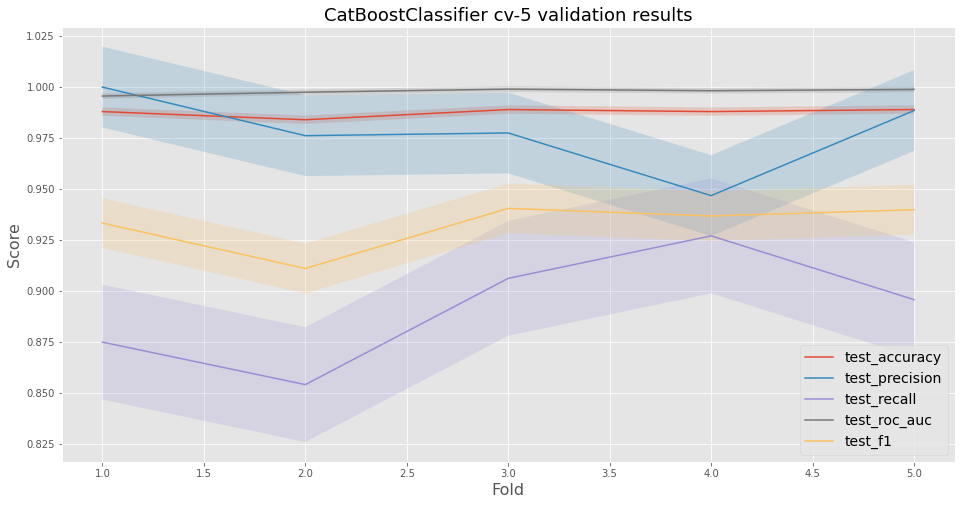

In [70]:
# vizualization
std_coef = 1.

plt.figure(figsize=(16, 8))

for column in model_cv_scores:
    if column != 'fold':
        plt.plot(model_cv_scores['fold'], model_cv_scores[column], label=column)
        plt.fill_between(x=model_cv_scores['fold'], 
                         y1=model_cv_scores[column]+std_coef*model_cv_scores[column].std(),
                         y2=model_cv_scores[column]-std_coef*model_cv_scores[column].std(),
                         alpha=.2)
        
        
plt.title('CatBoostClassifier cv-5 validation results', size=18)
plt.xlabel('Fold', size=16)
plt.ylabel('Score', size=16)

plt.legend(loc='lower right', fontsize=14);

In [71]:
res = model_pipeline.predict(X.sample(1))
res

array([0], dtype=int64)

In [72]:
#saving model
joblib.dump(model_pipeline, 'models\\final_model.pkl')

['models\\final_model.pkl']